# Lecture 22 - Part 1 - Applications of K-Means & Part 2: DBSCAN, Hierarchical Clustering & Cluster Validity Metrics

## K-Means Applications

K-Means is a very popular algorithm and is commonly used in a variety of applications, such as: market segmentation, document clustering, image segmentation, image compression, etc.

The *goal* usually when we undergo a cluster analysis is either:

1. Get a meaningful intuition of the structure of the data we are dealing with.

2. Cluster-then-predict where different models will be built for different subgroups. An example of that is clustering patients into different subgroups (based on some feature map) and build a model for each subgroup to predict the probability of the risk of having a heart attack.

Let's take a look at two case applications for K-Means: Image Compression and Data Segmentation.

In [3]:
from scipy.spatial.distance import cdist
from numpy.random import permutation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

### Example: K-Means as Image Compression

*Example and code from book ["Data Science Handbook" by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html)*

One interesting application of clustering is in color compression within images. For example, imagine you have an image with millions of colors. In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

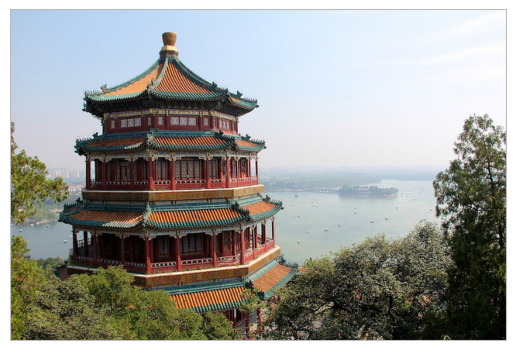

In [4]:
from sklearn.datasets import load_sample_image

image = load_sample_image('china.jpg')
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(image);

The image itself is stored in a three-dimensional array of size (height, width, RGB), containing red/blue/green contributions as integers from 0 to 255:

In [5]:
image.shape

(427, 640, 3)

One way we can view this set of pixels is as a cloud of points in a three-dimensional color space. We will reshape the data to $[$n_samples $\times$ n_features$]$, and rescale the colors so that they lie between 0 and 1:

In [6]:
# min-max scaling
data = image / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

We can visualize these pixels in this color space, using a subset of 10,000 pixels for efficiency:

In [7]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

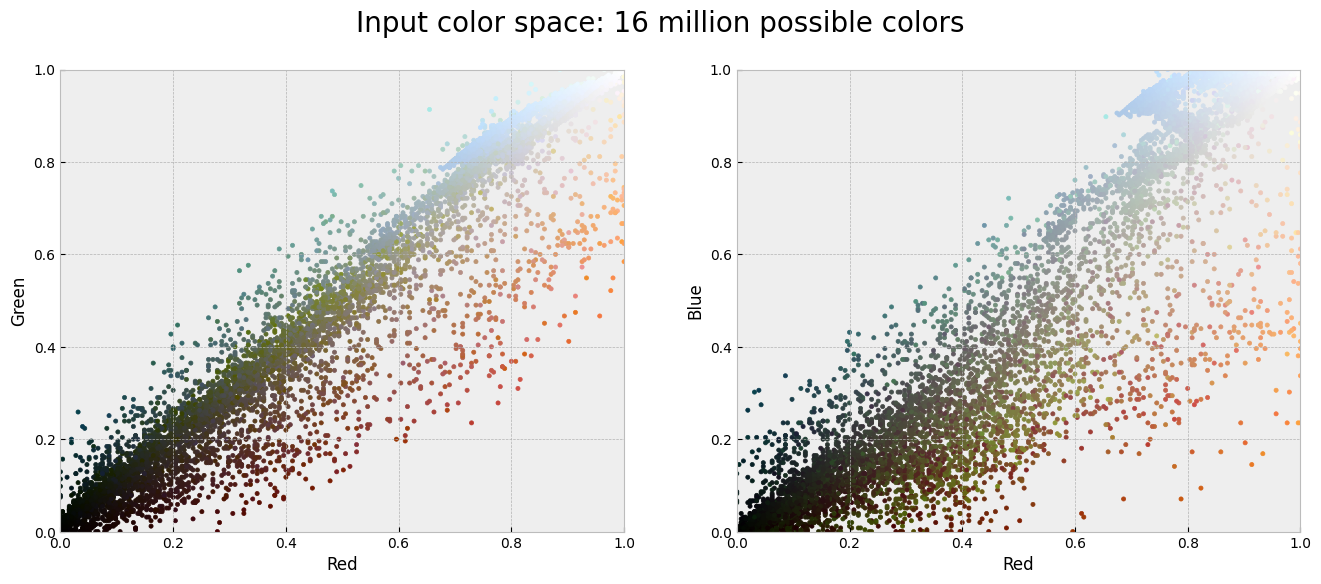

In [8]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Now let's reduce these 16 million colors to just 16 colors, using K-Means clustering across the pixel space.

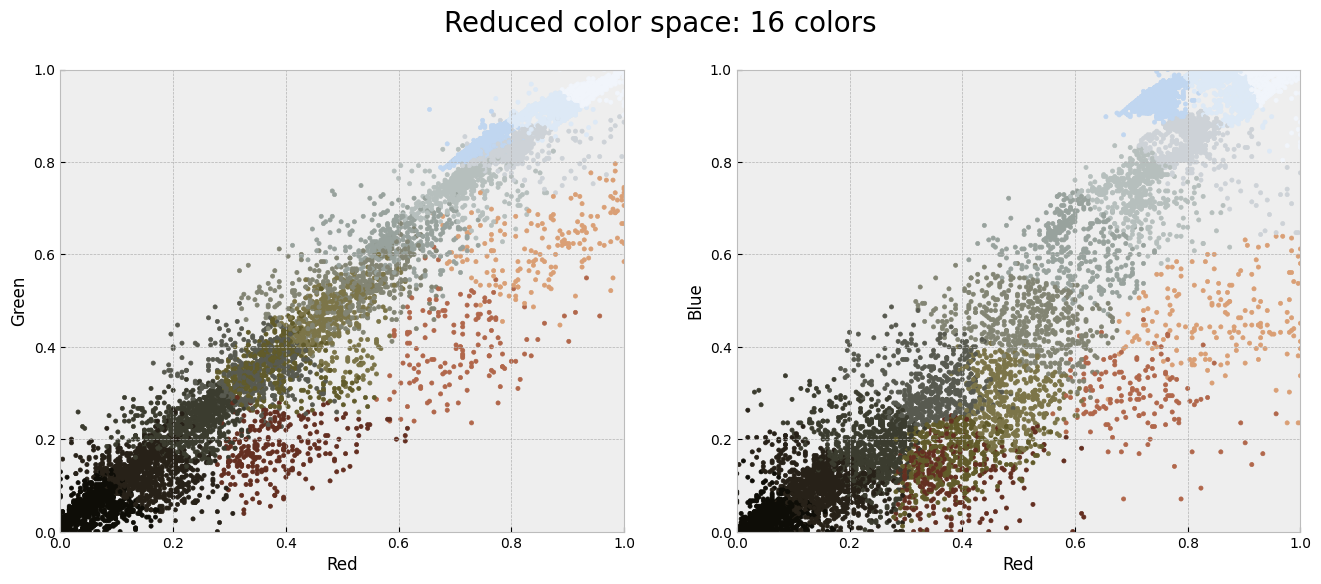

In [9]:
from sklearn.cluster import KMeans as KMeans_sklearn

kmeans = KMeans_sklearn(16, n_init='auto')
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors, title="Reduced color space: 16 colors")

The result is a re-coloring of the original pixels, where each pixel is assigned the color of its closest cluster center. Plotting these new colors in the image space rather than the pixel space shows us the effect of this:

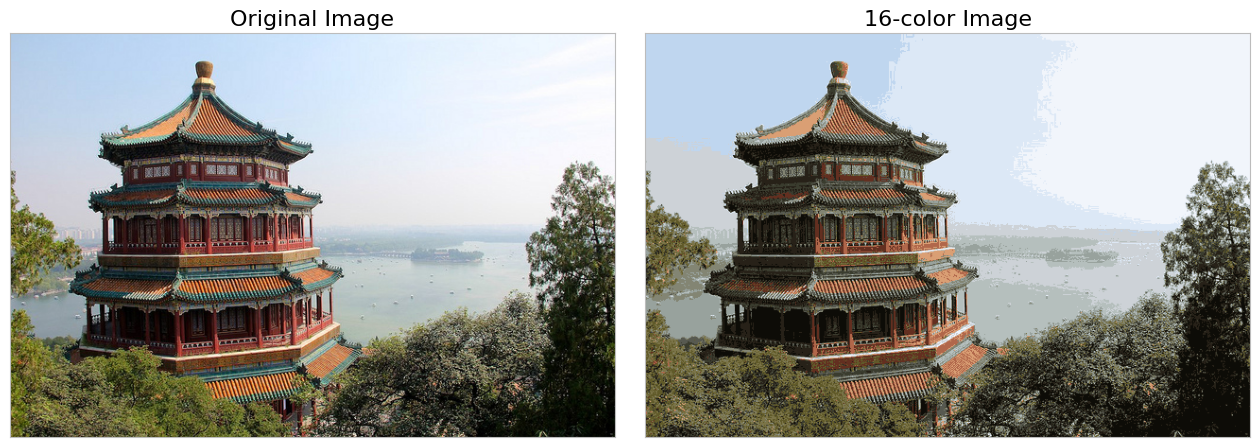

In [10]:
image_recolored = new_colors.reshape(image.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(image)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(image_recolored)
ax[1].set_title('16-color Image', size=16);

Some detail is certainly lost in the rightmost panel, but the overall image is still easily recognizable. This image on the right achieves a compression factor of around 1 million! While this is an interesting application of k-means, there are certainly better ways to compress information in images. But the example shows the power of thinking outside of the box with unsupervised methods like k-means.

___

## Using Clustering for Preprocessing

Clustering can be an efficient preprocessing step before a supervised learning algorithm. As an example of using clustering for preprocessing, let;s tackle the digits dataset, which is a simple MNIST-like dataset containing 1,797 grayscale $8\times 8$ images representing the digits 0 to 9. First, load the dataset:

In [11]:
from sklearn.datasets import load_digits 
X=load_digits()
X.keys()


dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [12]:
X_digits, t_digits = load_digits(return_X_y=True) 

X_digits.shape, t_digits.shape

((1797, 64), (1797,))

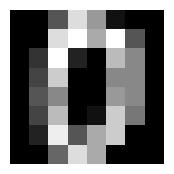

In [13]:
plt.figure(figsize=(2,2))
plt.imshow(X_digits[0,:].reshape(8,8), cmap='gray')
plt.axis('off');

Now, split it into a training set and a test set:

In [14]:
from sklearn.model_selection import train_test_split 

X_train, X_test, t_train, t_test = train_test_split(X_digits, t_digits,
                                                   stratify=t_digits,
                                                   random_state=0) 

Next, fit a Logistic Regression model:

In [15]:
from sklearn.linear_model import LogisticRegression 

log_reg = LogisticRegression(solver='liblinear') 

# Training Model
log_reg.fit(X_train, t_train) 

# Performance in Test Set
log_reg.score(X_test, t_test)

0.9511111111111111

OK, that's our baseline: 95.6% accuracy. Let's see if we can do better by using K-Means as a preprocessing step. We will create a pipeline that will first cluster the training set into 50 clusters and replace the images with their distances to these 50 clusters, then apply a Logistic Regression model:

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

In [17]:
pipeline = Pipeline([('kmeans', KMeans(n_clusters=50)), # the output is a distance matrix of shape Nx50
                     ('log_reg', LogisticRegression(solver='liblinear'))]) 

pipeline.fit(X_train, t_train)

pipeline.score(X_test, t_test)

0.9844444444444445

We chose the number of clusters k arbitrarily; we can surely do better. Since K-Means is just a preprocessing step in a classification pipeline, finding a good value for $k$ is simply the one that results in the best classification performance during cross-validation. We can use ```GridSearchCV``` to find the optimal number of clusters:

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(50, 100)) 

grid_clf = GridSearchCV(pipeline, 
                        param_grid, 
                        cv=3,
                        verbose=1) 

grid_clf.fit(X_train, t_train) 

print(grid_clf.best_params_)

grid_clf.score(X_test, t_test)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'kmeans__n_clusters': 87}


0.9822222222222222

## Using Clustering for Semi-Supervised Learning 

Another use case for clustering is in semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances. Let's train a Logistic Regression model on a sample of 50 labeled instances from the digits dataset:

In [19]:
n_labeled = 50

log_reg = LogisticRegression() 

log_reg.fit(X_train[:n_labeled], t_train[:n_labeled]) 

LogisticRegression()

What is the performance of this model on the test set?

In [20]:
log_reg.score(X_test, t_test)

0.8

The accuracy is just ~80%. It should come as no surprise that this is much lower than earlier, when we trained the model on the full training set. Let's see how we can do better. First, let's cluster the training set into 50 clusters. Then for each cluster, let's find the image closest to the centroid. We will call these images the representative images:

In [21]:
k = 50 

kmeans = KMeans(n_clusters=k, random_state=3) 

# distance of each sample to the cluster centroid
X_digits_dist = kmeans.fit_transform(X_train) 

X_digits_dist.shape

(1347, 50)

In [22]:
# find the representative sample
# the one with the closest distance to the cluster centroid

representative_digit_idx = np.argmin(X_digits_dist, axis=0)

representative_digit_idx.shape

representative_digit_idx

array([1085,  389,    3, 1107,  926,  109, 1323,   95,  647,  829,  841,
        728, 1324, 1078,  601, 1272,  170,  107,  343,  489, 1246, 1149,
        651,  886,   42,  400,  858,  421,  877,  140,  479, 1077,  477,
        498,  124, 1160,   46, 1020,  922,  842,  258,  585,  890,   72,
         41,  331,  444,  950,  923, 1156], dtype=int64)

In [23]:
X_representative_digits = X_train[representative_digit_idx]

X_representative_digits.shape

(50, 64)

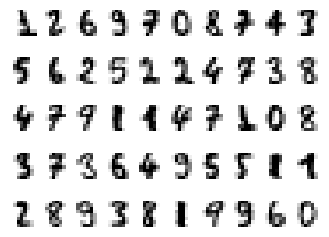

In [24]:
plt.figure(figsize=(4,3))
for i in range(k):
    plt.subplot(5,10,i+1)
    plt.imshow(X_representative_digits[i,:].reshape(8,8), cmap='binary')
    plt.axis('off')

Let's look at each image and manually label it:

In [25]:
t_representative_digits = np.array([1,2,6,9,7,0,8,7,4,3,
                                   5,6,2,5,1,1,4,7,3,8,
                                   4,7,9,1,1,4,7,1,0,8,
                                   3,7,3,6,4,9,5,5,8,1,
                                   2,8,9,3,8,1,4,9,6,0])

Now we have a dataset with just 50 labeled instances, but instead of being random instances, each of them is a representative image of its cluster. Let's see if the performance is any better:

In [26]:
log_reg = LogisticRegression()

log_reg.fit(X_representative_digits, t_representative_digits)

log_reg.score(X_test, t_test)

0.8622222222222222

Wow! We jumped from ~80% accuracy to ~87%, although we are still only training the model on 50 instances. Since it is often costly and painful to label instances, especially when it has to be done manually by experts, it is a good idea to label representative instances rather than just random instances. But perhaps we can go one step further: what if we propagated the labels to all the other instances in the same cluster? This is called **label propagation**.

In [27]:
t_train_propagated = np.empty(len(X_train)) 

for i in range(k): 
    t_train_propagated[kmeans.labels_==i] = t_representative_digits[i]

t_train_propagated.shape

(1347,)

Now let's train the model again and look at its performance:

In [28]:
log_reg = LogisticRegression(solver='liblinear')

log_reg.fit(X_train, t_train_propagated)

log_reg.score(X_test, t_test)

0.8755555555555555

---

# Density-based Spatial Clustering of Applications with Noise (DBSCAN)

In density-based clustering, a cluster is formed if there is a *sufficient* amount of neighboring points (density). In DBSCAN, each point is marked as one of three categories: 

* a **core point**, which is surrounded by a certain number of neighboring points in a given radius; 

* a **border point**, which is not surrounded by the same amount of neighboring points but is within a radius of a core point; and 

* a **noise point**, which is any other point that does not fall into the other two categories. 

With these markings, the DBSCAN algorithm forms clusters for groups of core points and assigns the border points to the cluster with their respective core point. 

Moreover, core points that are density-reachable from each other belong to the same cluster. If core points are close enough (within $\epsilon$), they merge into a single cluster

![DBSCAN with 4 neighbors](https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/DBSCAN-Illustration.svg/1280px-DBSCAN-Illustration.svg.png)

The parameters are: 

1. *MinPts*: the value for the minimum number of neighboring points, this will determine the number of points a core point must have in order to be marked as a core point; 

2. $\epsilon$: the radius parameter determines a fixed radius region in which neighboring points must *live on* in order to be marked as a core point or border point.

3. Distance metric: the distance metric used to compute distances and neighbors.

## Discussions

* DBSCAN has the advantage over both k-means and GMM in which it **finds clusters without needing to define the number of clusters a priori**. 

* DBSCAN has the advantage over k-means as it is able to find groups with different number of points (different densities) and without making explicit assumptions about cluster shape. 

* DBSCAN has the advantage over distribution-based clustering (with for example Gaussian Mixture Models or GMM) because it is of much lower computational complexity, in the order of $O(N\log(N))$. 

* Moreover, DBSCAN is able to mark points as noise points, making it robust against outliers for subsequent classification task.

* As with any algorithm that uses distances, DBSCAN will too be heavily affected by the curse of dimensionality. DBSCAN will also have trouble finding clusters with different densities (number of points).

In [29]:
from sklearn.cluster import DBSCAN

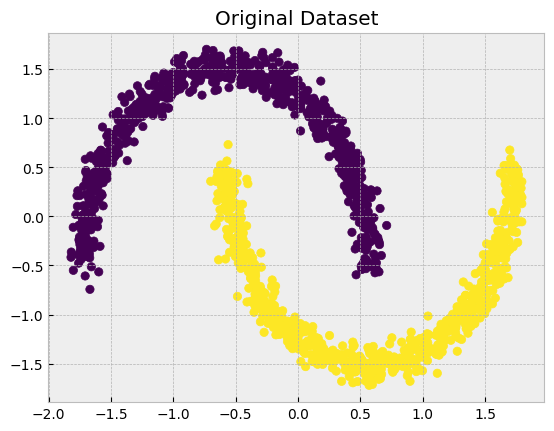

In [30]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler

# Dataset
dataset, true_labels = make_moons(n_samples=1500, noise=.05)

# Feature scaling
scaler = StandardScaler()
dataset = scaler.fit_transform(dataset)

plt.scatter(dataset[:,0],dataset[:,1], c=true_labels); plt.title('Original Dataset');

In [45]:
dataset

array([[-1.26275309,  1.04857148],
       [-1.6296041 ,  0.37956421],
       [ 0.12662106,  0.90319797],
       ...,
       [-0.19581047, -1.0429542 ],
       [-0.07136643,  1.27237863],
       [ 0.46452005, -1.51633899]])

In [46]:
true_labels

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

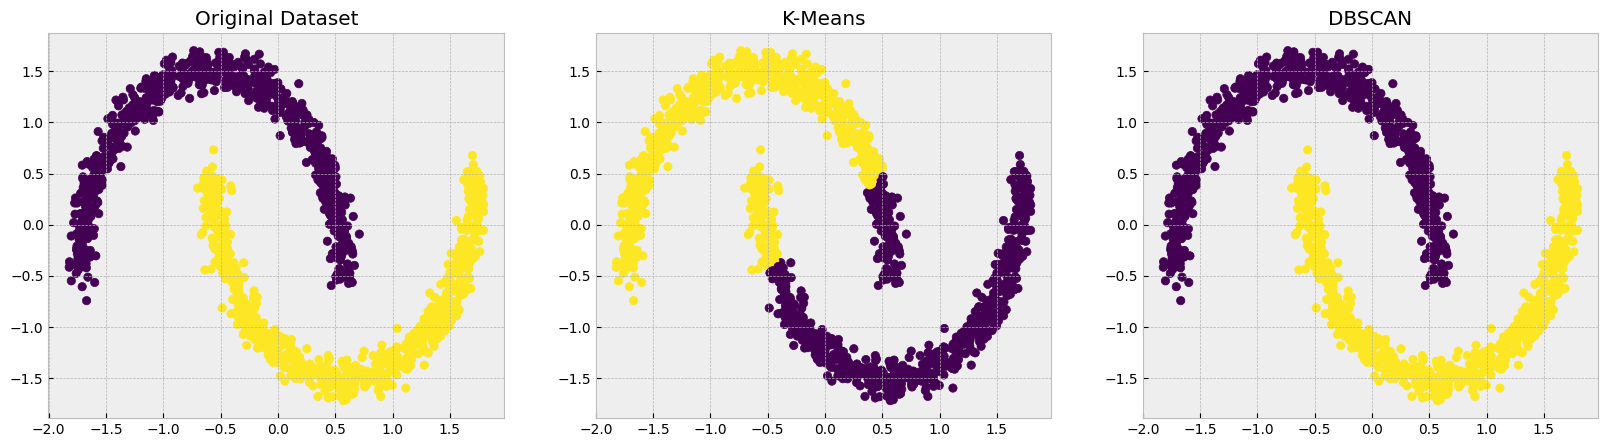

In [ ]:
# K-Means
kmeans = KMeans(n_clusters=2, n_init='auto')
labels_kmeans = kmeans.fit_predict(dataset)

#DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=10) #eps=0.2 = Two points within distance 0.2 are considered close neighbors.
labels_dbscan = dbscan.fit_predict(dataset)

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.scatter(dataset[:,0],dataset[:,1], c=true_labels); plt.title('Original Dataset')
plt.subplot(1,3,2)
plt.scatter(dataset[:,0],dataset[:,1], c=labels_kmeans); plt.title('K-Means')
plt.subplot(1,3,3)
plt.scatter(dataset[:,0],dataset[:,1], c=labels_dbscan); plt.title('DBSCAN');

In [32]:
dbscan.core_sample_indices_

array([   0,    1,    2, ..., 1497, 1498, 1499], dtype=int64)

In this example, we obtain two clusters because the core points within the upper half-moon are density-connected (within distance $\epsilon$ of each other), forming a single cohesive cluster. Similarly, the core points in the lower half-moon connect to form the second cluster.

In [33]:
len(dbscan.core_sample_indices_)

1495

In [34]:
dbscan.labels_

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

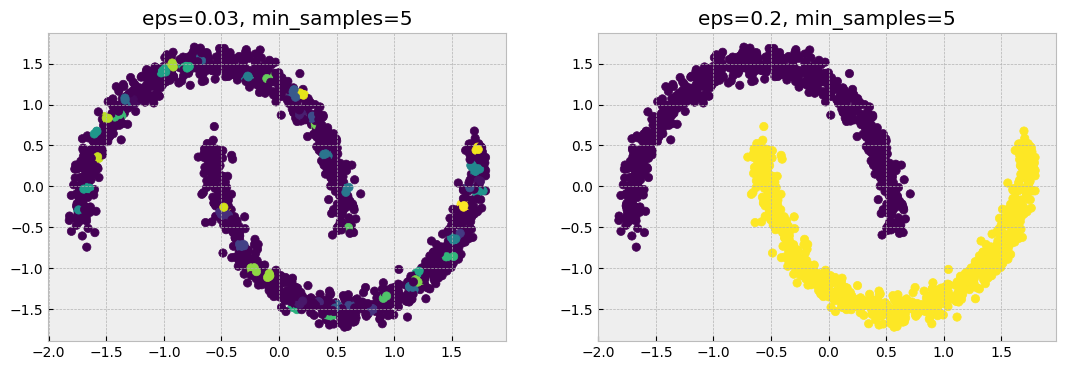

In [35]:
plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
dbscan = DBSCAN(eps=0.03, min_samples=5)
labels_dbscan = dbscan.fit_predict(dataset)
plt.scatter(dataset[:,0],dataset[:,1], c=labels_dbscan); 
plt.title('eps=0.03, min_samples=5')

plt.subplot(1,2,2)
dbscan = DBSCAN(eps=0.2, min_samples=5)
labels_dbscan = dbscan.fit_predict(dataset)
plt.scatter(dataset[:,0],dataset[:,1], c=labels_dbscan); 
plt.title('eps=0.2, min_samples=5');

---

# Cluster Validity Metrics

How would you evaluate clustering results? - **Cluster Validity Indices**
    
* Cluster validity indices are used for a number of different goals. For example, cluster validity metrics can be used to compare clustering results, try to determine the *correct* number of clusters, try to select the *correct* parameter settings, try to evaluate the appropriateness of the clustering result based on the data only (and not using another result or "ground truth" data).
    
In general, there are three types of **index criteria** to perform cluster validity:

1. **Internal criteria.** We evaluate the results of a clustering algorithm in terms of quantities that involve the vectors of the data set themselves. 
2. **External criteria.** We evaluate the results of a clustering algorithm based on a pre-specified structure, which is imposed on a data set and reflects our intuition about the clustering structure of the data set.

## Internal Criteria 

As the goal of clustering is to make objects within the same cluster similar and objects in different clusters distinct, internal cluster validity measures are defined by combining compactness and separability.

The optimal clustering scheme under the internal criteria index includes:

* Compactness (or intra-distance or within-cluster scatter): The members of each cluster should be as close to each other as possible. A common measure of compactness is the variance, which should be minimized.
* Separation (or inter-distance or between-cluster scatter): This indicates how distinct two clusters are. It computes the distance between two different clusters. There are three common approaches measuring the distance between two different clusters:
    * Single linkage: It measures the distance between the closest members of the clusters. 
    * Complete linkage: It measures the distance between the most distant members. 
    * Comparison of centroids: It measures the distance between the centers of the clusters. 

### Example: Silhouette Index

The Silhoute Index is an internal cluster validity index that is used to judge the quality of any clustering solution. 

Given a set of data points $X=\{x_1,\dots,x_N\}$ and a partition of $X$ (i.e. clustering result). Let's define the following:
* $a_i$ is the average distance of the point $x_i$ to all the other points of the cluster in which $x_i$ is assigned to
* $b_i$ is the average distance of the point $x_i$ to all the other points of in the other clusters. 

For every data point $x_i \in X$, the Silhouette Index is defined as:

$$s = \frac{1}{N} \sum_{i=1}^N \frac{b_i-a_i}{\max(a_i,b_i)}$$

* Silhouette index is the average silhouette of all data points and it reflects the compactness and separation of clusters.

* The value of silhouette index varies from -1 and 1 and higher indicates better clustering results.

There are many other internal cluster validity indices!

## External Criteria

External cluster validity indices are used to measure how well a clustering result matches a set of *give* labels. 
External cluster validity indices can be used to:
* compare the clustering results with the *ground truth* (true labels),
* compare clustering results between different clustering algorithms to measure how different they are and how stable a particular clustering is on a data set across parameter settings and/or algorithms.

### Example: Rand Index

The Rand Index is an external cluster validity index that is used to compare clustering results obtained from different parameter settings or algorithms. 

Given a set of data points $X$ and two partitions (i.e. clustering results) of $X$ to compare. One partition $C=\{C_1, \dots,C_k\}$, that partitions $X$ into $k$ clusters, and another partition $D=\{D_1,\dots,D_s\}$, that partitions $X$ into $s$ clusters. Let's define the following:

* $a$ is the number of pairs of elements in $X$ that are in the same subset in $C$ and in the same subset in $D$.
* $b$ is the number of pairs of elements in $X$ that are in different subset in $C$ and in different subset in $D$.
* $c$ is the number of pairs of elements in $X$ that are in the same subset in $C$ and in different subset in $D$.
* $d$ is the number of pairs of elements in $X$ that are in different subset in $C$ and in the same subset in $D$.

The Rand Index is defined as:

$$r = \frac{a+b}{a+b+c+d}$$

* Intuitively, $a+b$ can be considered as the number of *agreements* between $C$ and $D$, and $c+d$ as the number of *disagreements* between $C$ and $D$.

* The value of rand index varies from 0 and 1 and higher indicates higher consistency between partitions $C$ and $D$.

There are many other external cluster validity indices!

In [36]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import load_wine
from sklearn.cluster import KMeans, AgglomerativeClustering

In [37]:
wine = load_wine(return_X_y=False)
# print(wine.DESCR)

df_wine = pd.DataFrame(np.hstack((wine.target[:,np.newaxis],wine.data)), columns=['Class']+wine.feature_names)
df_wine

,Class,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,0.0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,0.0,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,0.0,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,0.0,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,0.0,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,2.0,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,2.0,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,2.0,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,2.0,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


In [38]:
from sklearn.metrics import silhouette_score, rand_score

In [39]:
## Loading data and Standardization
X = df_wine[df_wine.columns[1:]].to_numpy() # Training Data
scaler = MinMaxScaler() # Scaling data using standardization
X_scaled = scaler.fit_transform(X)

# Training the final clustering algorithms (with the nest returned k value)
labels = KMeans(n_clusters=3, n_init='auto',random_state=1).fit_predict(X_scaled)

# Computing the rand score
print('Silhouette Score: ', silhouette_score(X_scaled, labels)) 
print('Rand Score: ', rand_score(wine.target, labels)) 

Silhouette Score:  0.3000578259304104
Rand Score:  0.9264901923443154


Silhouette Score = “Is my clustering good?” (no true labels needed)

Rand Score = “Does my clustering match the real labels?” (needs true labels)

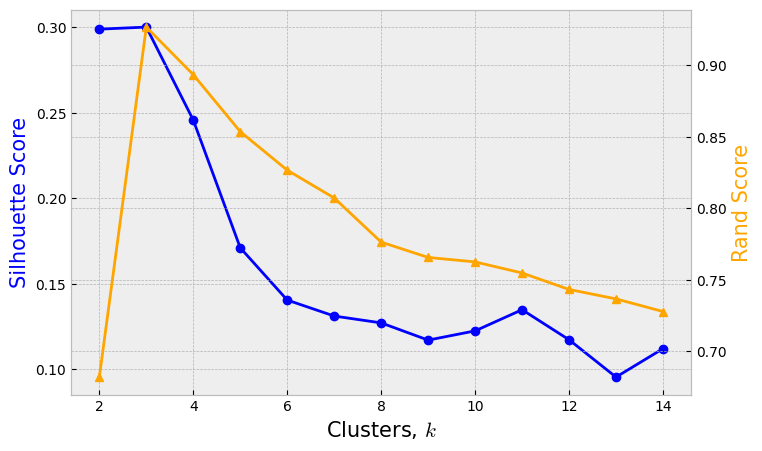

In [40]:
## Routine to determine which k value works best for each criteria
ss = [] # silhouette score
rs = [] # rand score
for k in range(2,15):
    labels = KMeans(n_clusters=k,random_state=1, n_init='auto').fit_predict(X_scaled) # Training K-Means
    ss+=[silhouette_score(X_scaled, labels)] #appending silhouette score for clustering results
    rs+=[rand_score(wine.target, labels)] #appending rand andscore for clustering results

## Plotting results
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(range(2,15), ss,'-ob', label='Silhouette Score')
ax.set_xlabel('Clusters, $k$',size=15); ax.set_ylabel('Silhouette Score',c='b',size=15)
ax2=ax.twinx(); ax2.plot(range(2,15), rs, '-^',color='orange', label='Rand Score')
ax2.set_ylabel('Rand Score',c='orange',size=15);

Here is a **super simple, baby-language explanation** of the graph you posted.
I’ll explain **what the lines mean**, **why they go up/down**, and **what you should conclude**. ❤️

---

# 🌟 **What the graph shows**

The graph shows **how the clustering quality changes** when you change the number of clusters **k**.

* **Blue line = Silhouette Score** (internal quality)
* **Orange line = Rand Score** (external quality)
* **X-axis = number of clusters k**

We are basically checking:

👉 “If I change k, do my clusters get better or worse?”
👉 “What is the best value of k?”

---

# 🔵 **BLUE Line — Silhouette Score (Internal Quality)**

Baby meaning:

### **“Are clusters tight and well separated?”**

### 🔵 What the blue line is doing:

* Highest at **k = 3**
* Slowly decreases as k increases
* Becomes very low for large k (12, 13, 14)

### 🔵 Why this happens:

When k is small = clusters are bigger = more meaningful
When k increases = clusters get tiny = become meaningless

### 🔵 Interpretation:

👉 **The best silhouette score is around k = 3**
👉 Means the data naturally forms about **3 good clusters** internally

(But the real “correct” number depends on the true shape of your dataset.)

---

# 🟠 **ORANGE Line — Rand Score (External Quality)**

Baby meaning:

### **“How much do predicted clusters match the true labels?”**

### 🟠 What the orange line is doing:

* Big jump at k = 3 (highest value)
* Then slowly decreases as k goes above 3
* Slowly drops from ~0.90 down to ~0.70

### 🟠 Why this happens:

Rand score compares your clustering to the **true labels**.

* If k = correct number of true clusters → score is high
* If k is wrong → score decreases
* If k is too big → model splits real clusters → score drops

### 🟠 Interpretation:

👉 **Best matching with true labels is also around k = 3**

---

# 🌈 **Final Combined Meaning**

Both internal (silhouette) and external (rand) evaluations are telling you the same thing:

### ⭐ **Best number of clusters = 3**

Why?

* At **k = 3**,

  * Clusters are tight + well separated
  * Clusters match real labels best

* As k increases:

  * Silhouette goes down → clusters get worse
  * Rand goes down → clusters no longer match true labels

---

# 🍼 **Baby Analogy**

Imagine dividing kids into groups for a game.

* When you make **3 groups**, kids are grouped nicely and match the teacher’s list → everyone is happy.
* When you make **10 groups**, kids get split randomly and do not match the teacher’s real groups → chaos.

---

# ⭐ FINAL SUMMARY

### 🔵 Silhouette → measures cluster quality inside the dataset

### 🟠 Rand → measures match with true labels

### Both peak at **k = 3**

→ This means **k = 3 is the best number of clusters** for this dataset.

---

If you want, I can explain **why silhouette drops** or **why rand score peaks at correct k**, or even help you compute these scores in Python!
"

We can also compare several clustering algorithms for the same number of clusters:

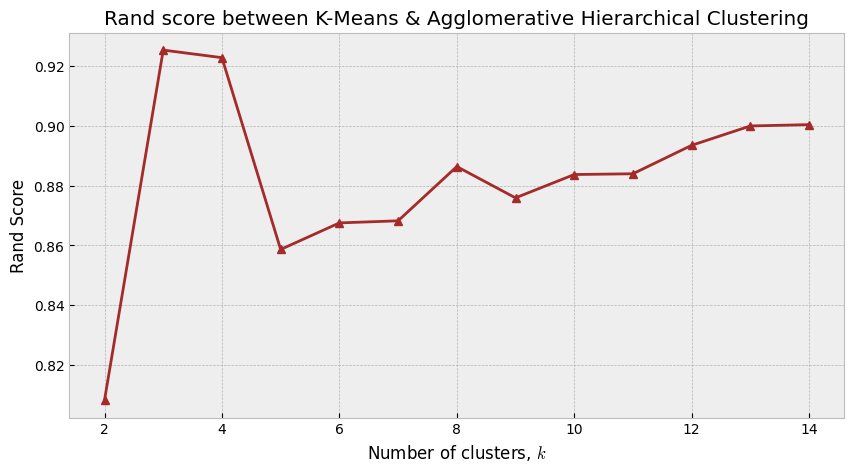

In [41]:
## Routine to determine which k value works best for each criteria
rs = [] # rand score
for k in range(2,15):
    labels_kmeans = KMeans(k,random_state=1, n_init='auto').fit_predict(X_scaled) # Training K-Means
    labels_agglom = AgglomerativeClustering(n_clusters=k).fit_predict(X_scaled)
    rs+=[rand_score(labels_kmeans, labels_agglom)] #appending rand score for clustering results

## Plotting results
plt.figure(figsize=(10,5))
plt.plot(range(2,15), rs, '-^', color='brown');
plt.title('Rand score between K-Means & Agglomerative Hierarchical Clustering')
plt.xlabel('Number of clusters, $k$')
plt.ylabel('Rand Score');

---